<a href="https://colab.research.google.com/github/AleksandrRevuka/Algo_data_science/blob/main/6_Practical_skills_1_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

In [15]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

In [16]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() / 1024 ** 2
  for col in df.columns:
    col_type = df[col].dtypes
    if str(col_type)[:5] == "float":
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
        df[col] = df[col].astype(np.float16)
      elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
        df[col] = df[col].astype(np.float32)
      else:
        df[col] = df[col].astype(np.float64)
    elif str(col_type)[:3] == "int":
        c_min = df[col].min()
        c_max = df[col].max()
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(np.int64)
    elif col == "timestamp":
      df[col] = pd.to_datetime(df[col])
    elif str(col_type)[:8] != "dataetime":
      df[col] = df[col].astype("category")
  end_mem = df.memory_usage().sum() / 1024 ** 2
  print(f"Споживання памяті меньше на {round(start_mem - end_mem, 2)}Mb (мінус {round(100 * (start_mem - end_mem) / start_mem, 1)}%)")
  return df

In [17]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Споживання памяті меньше на 0.05Mb (мінус 73.9%)
Споживання памяті меньше на 6.53Mb (мінус 68.1%)
Споживання памяті меньше на 195.54Mb (мінус 53.1%)


In [18]:
def round_fillna(df, columns):
  for col in columns:
    type_ = "int8"
    if col in ["wind_speed", "cloud_coverage", "precip_depth_1_hr"]:
      type_ = "int16"
    if col == "precip_depth_1_hr":
      df[col] = df[col].apply(lambda x: 0 if x < 0 else x)
    df[col] = np.round(df[col].fillna(value=0)).astype(type_)
  return df

In [19]:
energy = pd.merge(left=energy, right=buildings, how="left", left_on="building_id", right_on="building_id")

energy.set_index(["timestamp", "site_id"], inplace=True)
weather.set_index(["timestamp", "site_id"], inplace=True)

energy = pd.merge(left=energy, right=weather, how="left", left_index=True, right_index=True)
energy.reset_index(inplace=True)
energy = energy.drop(columns=["meter"], axis=1)

energy = round_fillna(energy, ["wind_direction", "wind_speed", "cloud_coverage", "precip_depth_1_hr", "year_built", "floor_count"])
energy = energy[energy['meter_reading'] > 0]

del buildings
del weather
energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530741 entries, 45 to 12060909
Data columns (total 15 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   site_id             int64         
 2   building_id         int16         
 3   meter_reading       float32       
 4   primary_use         category      
 5   square_feet         int32         
 6   year_built          int8          
 7   floor_count         int8          
 8   air_temperature     float16       
 9   cloud_coverage      int16         
 10  dew_temperature     float16       
 11  precip_depth_1_hr   int16         
 12  sea_level_pressure  float16       
 13  wind_direction      int8          
 14  wind_speed          int16         
dtypes: category(1), datetime64[ns](1), float16(3), float32(1), int16(4), int32(1), int64(1), int8(3)
memory usage: 549.8 MB


<Figure size 600x600 with 0 Axes>

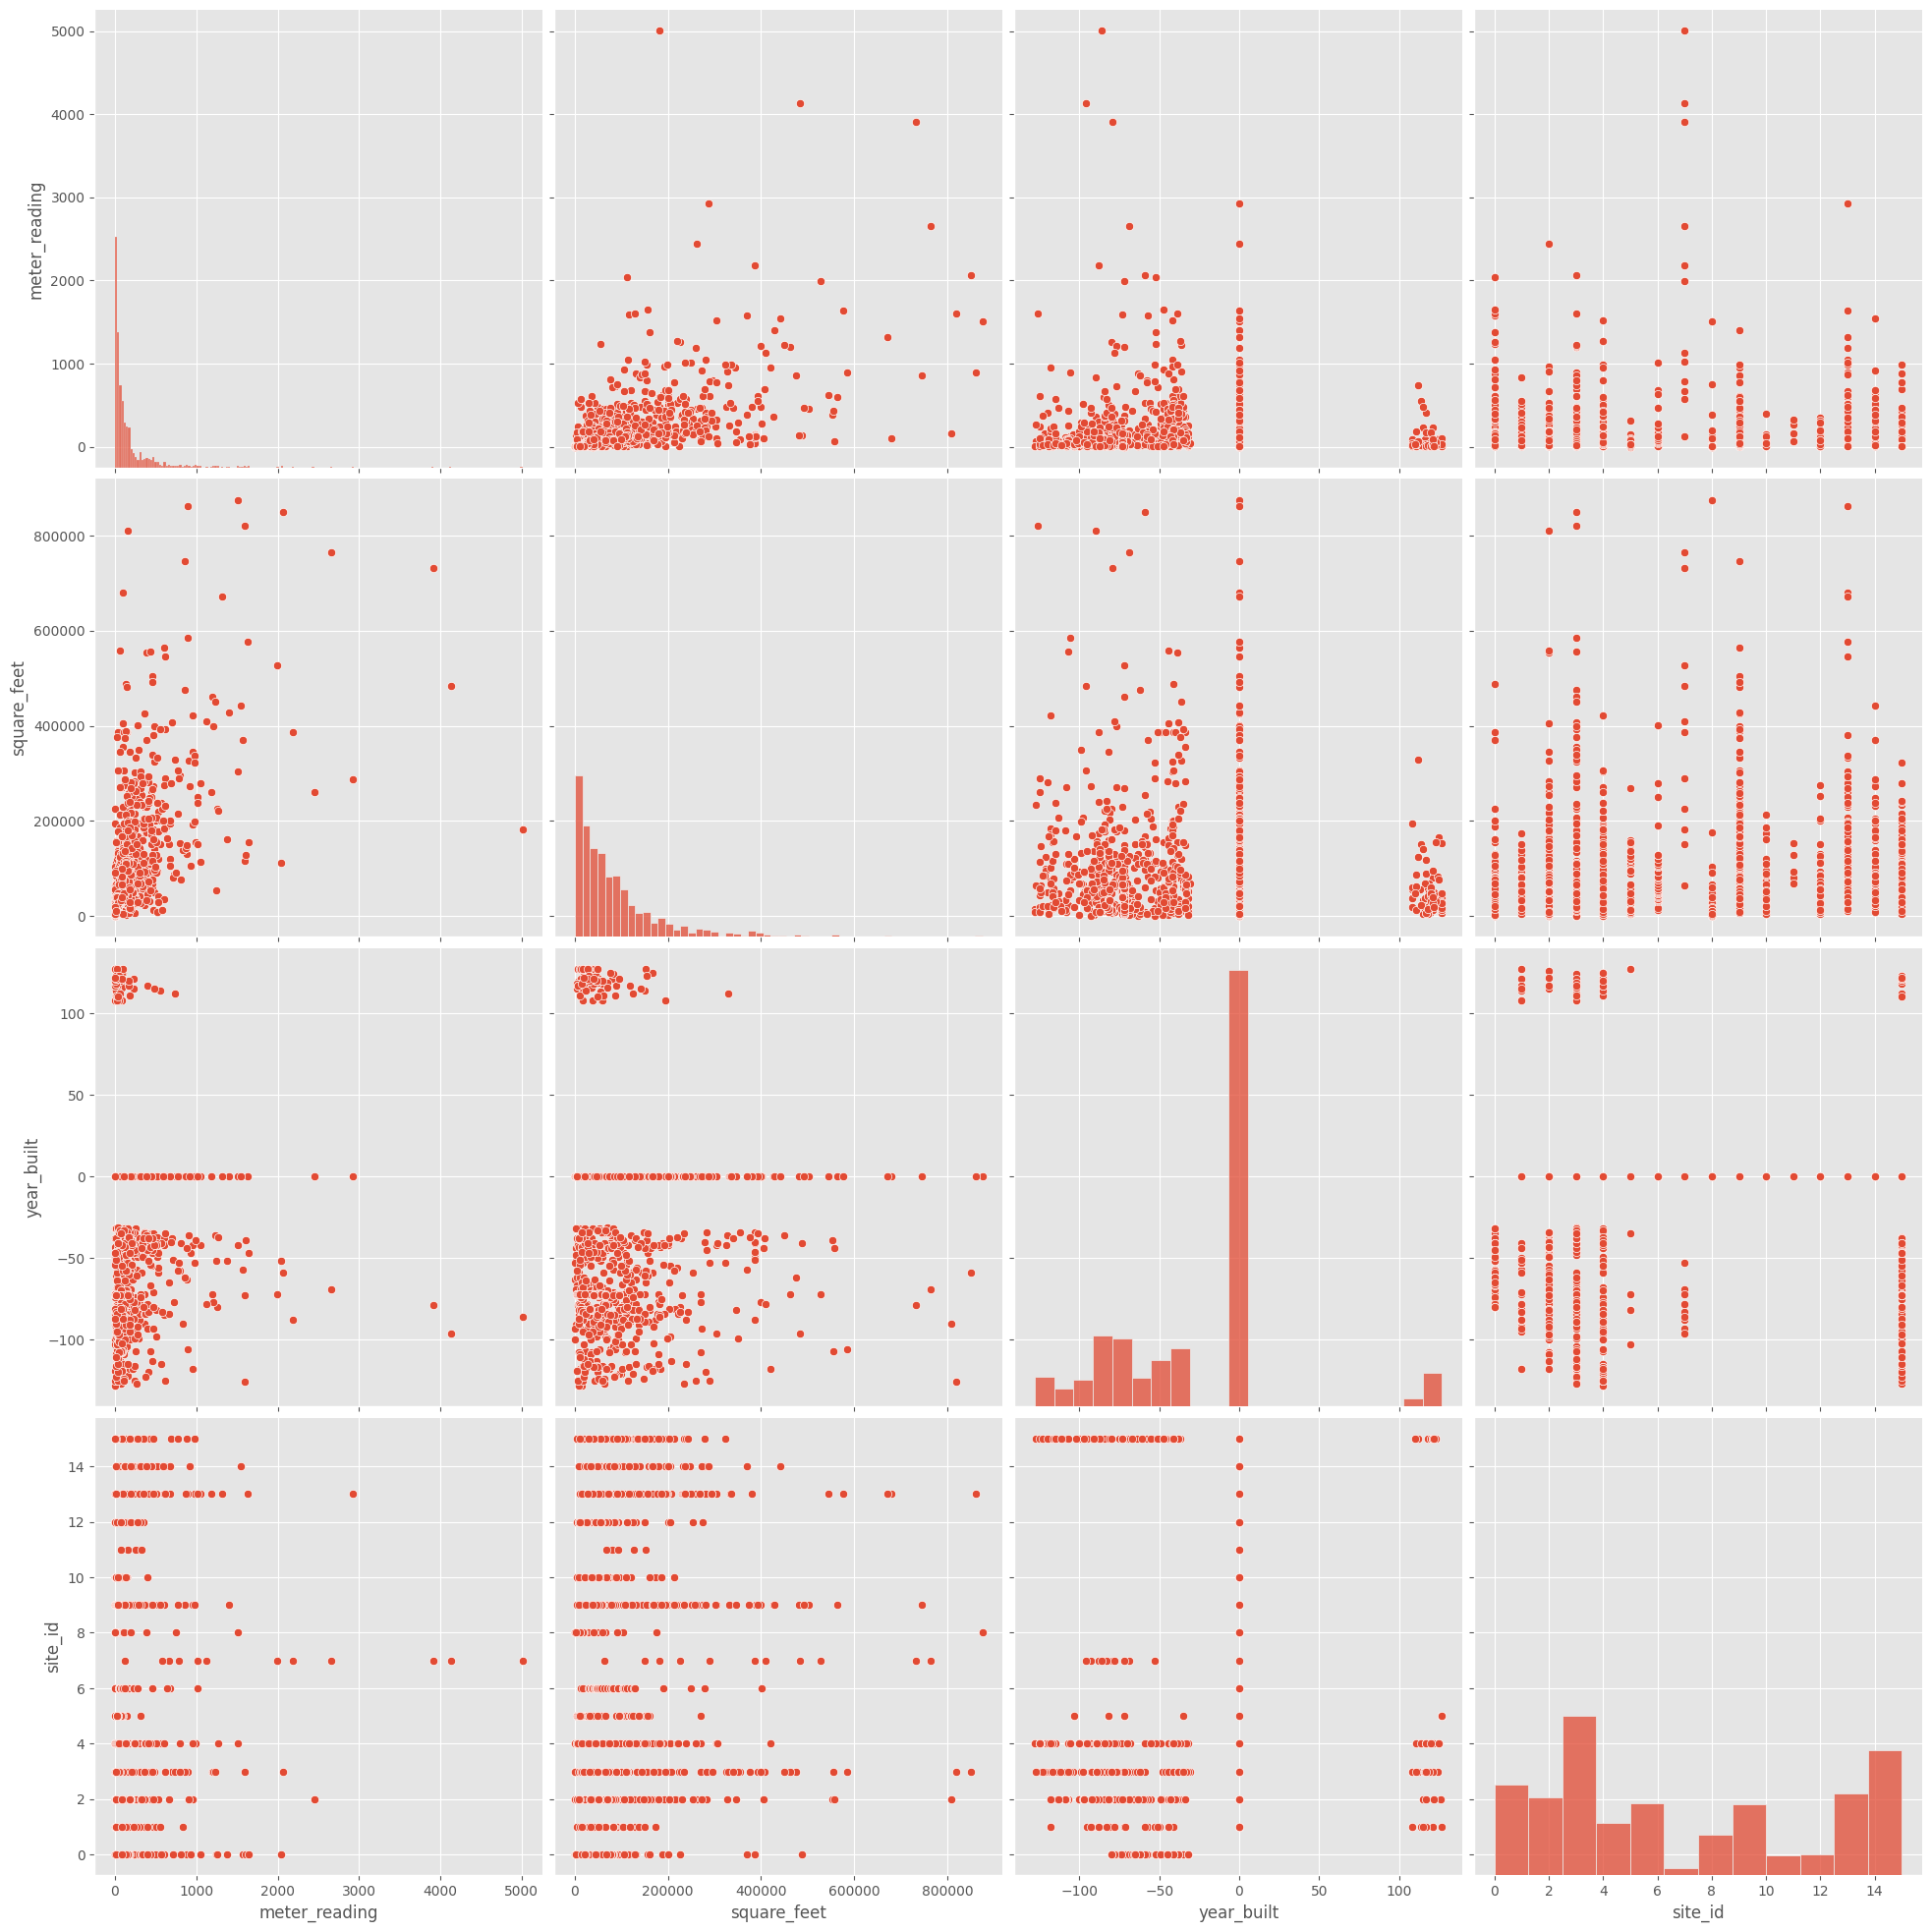

In [25]:
data_corr_meta = pd.DataFrame(
    energy.groupby("building_id")[["meter_reading", "square_feet", "year_built", "site_id"]].median()
)
data_corr_meta.dropna(inplace=True)
plt.style.use('ggplot')

plt.figure(figsize=(6, 6))
sns.pairplot(data_corr_meta, height=5)
plt.grid(linestyle='--')
plt.show()